In [42]:
import json
from collections import defaultdict
from statistics import mean, stdev
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from jinja2 import Template
import functools

In [20]:
@dataclass
class PlayerStats:
    id_: str = ""
    elo: int = 1000
    wins: int = 0
    loses: int = 0
    last_pseudo: str = ""
    pseudos: set = field(default_factory=set)
    perf_history: list = field(default_factory=list)
    slugs: set = field(default_factory=set)

    def update_elo(this, gain, opponant):
        perf = PerfHistory(opponant, this.elo, opponant.elo, gain)
        this.perf_history.append(perf)
        this.elo += gain

    def sets(this):
        return this.wins + this.loses

    def winrate(this):
        return this.wins / this.sets()

    def pic_elo(this):
        return max(this.elo_history())

    def worse_elo(this):
        return min(this.elo_history())

    def elo_history(this):
        return [p.my_elo for p in this.perf_history] + [this.elo]

    def plot_elo(this):
        plt.plot(this.elo_history())
        plt.show()

    def best_perf(this):
        return max(this.perf_history, key=lambda l: l.gain)

    def worse_perf(this):
        return min(this.perf_history, key=lambda l: l.gain)
    
    def participations(this):
        return len(this.slugs)


@dataclass
class PerfHistory:
    opponant: PlayerStats
    my_elo: float
    his_elo: float
    gain: float


def update_ratings(player_stats_1, player_stats_2, winner, k):
    if player_stats_1 == winner:
        actual_outcome = 1
        loser = player_stats_2
    elif player_stats_2 == winner:
        actual_outcome = 0
        loser = player_stats_1
    else:
        raise Exception("Nobody won !")

    winner.wins += 1
    loser.loses += 1

    expected_outcome = 1 / \
        (1 + 10**((player_stats_2.elo - player_stats_1.elo) / 400))

    player_1_gain = k * (actual_outcome - expected_outcome)
    player_2_gain = k * ((1 - actual_outcome) - (1 - expected_outcome))
    player_stats_1.update_elo(player_1_gain, player_stats_2)
    player_stats_2.update_elo(player_2_gain, player_stats_1)

    error = ((expected_outcome - actual_outcome) ** 2) ** 1/2

    return error


In [21]:
sets = json.load(open("data/all_sets.json", "r"))

In [39]:
def compute_elo(sets_, k):
    errors = []
    players_stats = defaultdict(PlayerStats)

    for set_ in sets_:
        slots = set_["slots"]

        if len(slots) != 2:
            raise Exception("Not 2 slots")

        players = []
        lookup_entrant_player = {}
        for slot in slots:
            entrant = slot["entrant"]
            participants = entrant["participants"]

            if len(participants) != 1:
                raise Exception("Not 1 participant")

            participant = participants[0]
            entrant_id = entrant["id"]
            player_id = participant["player"]["id"]
            entrant_name = entrant["name"]

            lookup_entrant_player[entrant_id] = player_id
            player_stats = players_stats[player_id]
            
            player_stats.id_ = player_id
            player_stats.pseudos.add(entrant_name)
            player_stats.last_pseudo = entrant_name

            players.append(player_stats)

        winner = players_stats[lookup_entrant_player[set_["winnerId"]]]
        player_stats_1, player_stats_2 = players
        player_stats_1.slugs.add(set_["slug"])
        player_stats_2.slugs.add(set_["slug"])

        error = update_ratings(player_stats_1, player_stats_2, winner, k)
        errors.append(error)

    return players_stats, errors

133


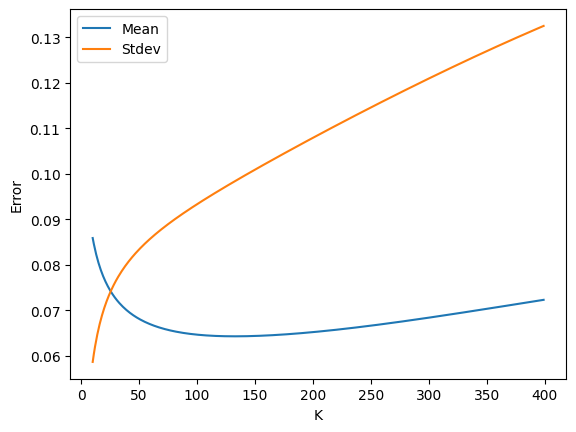

In [26]:
X = list(range(10, 400))
Y = []
Y2 = []
for i in X:
    players_stats, errors = compute_elo(sets, k=i)
    Y.append(mean(errors))
    Y2.append(stdev(errors))

minX = min(X, key=lambda i: Y[X.index(i)])
print(minX)

plt.plot(X,Y, label="Mean")
# plt.plot(X,Y2, label="Stdev")
plt.xlabel("K")
plt.ylabel("Error")
plt.legend()
plt.show()

In [54]:
def export(K, path):
    # MINIMAL_SETS_TO_BE_RANKED = 0
    # MINIMAL_ELO_TO_BE_RANKED = 0

    players_stats, errors = compute_elo(sets, k=K)

    ranking = list(players_stats.values())
    players_slugs = [p.slugs for p in ranking]
    all_slugs = set(functools.reduce(lambda a,b: a|b, players_slugs))
    # ranking = [p for p in ranking if p.sets() >= MINIMAL_SETS_TO_BE_RANKED]
    # ranking = [p for p in ranking if p.elo >= MINIMAL_ELO_TO_BE_RANKED]
    ranking.sort(key=lambda player_stats: -player_stats.elo)
    ranking = [(rank+1, p) for rank, p in enumerate(ranking)]


    pure_elos = [player_stats.elo for rank, player_stats in ranking]

    template_str = open("template.html", "r").read()
    template = Template(template_str)
    open(path, "w").write(template.render(
        ranking=ranking,
        mean=f"{mean(pure_elos):.2f}",
        stdev=f"{stdev(pure_elos):.2f}",
        total_sets=len(sets),
        total_players=len(players_stats),
        total_slugs=len(all_slugs),
        # minimal_sets=MINIMAL_SETS_TO_BE_RANKED,
        # minimal_elo=MINIMAL_ELO_TO_BE_RANKED,
        K=K,
        meanError=mean(errors),
        initial_elo=PlayerStats.elo
    ))

In [55]:
for K in [25, 50, 75, 100, 125, 133, 150, 175]:
    export(K, f"output/js_ranking_{K}.html")